In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.sonic.net/apache/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xzf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

import findspark
findspark.init()

We first create a new Spark session:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Read the CSV file saved in the */content* directory, printing the first 5 rows and columns names.

In [ ]:
df = spark.read.options(header=True, inferSchema=True).csv("./files/walmart_stock.csv")
df.show(5)
df.columns

+-------------------+------------------+---------+---------+------------------+--------+------------------+
|               Date|              Open|     High|      Low|             Close|  Volume|         Adj Close|
+-------------------+------------------+---------+---------+------------------+--------+------------------+
|2012-01-03 00:00:00|         59.970001|61.060001|59.869999|         60.330002|12668800|52.619234999999996|
|2012-01-04 00:00:00|60.209998999999996|60.349998|59.470001|59.709998999999996| 9593300|         52.078475|
|2012-01-05 00:00:00|         59.349998|59.619999|58.369999|         59.419998|12768200|         51.825539|
|2012-01-06 00:00:00|         59.419998|59.450001|58.869999|              59.0| 8069400|          51.45922|
|2012-01-09 00:00:00|         59.029999|59.549999|58.919998|             59.18| 6679300|51.616215000000004|
+-------------------+------------------+---------+---------+------------------+--------+------------------+
only showing top 5 rows



['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

We can observe the schema of the DataFrame. *Date* variable is a timestamp data type, *Volume* is an integer, and the rest of the variables are doubles.

In [ ]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



Here we can see a basic statistical analysis of the data.

In [ ]:
df.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|summary|              Open|             High|              Low|            Close|           Volume|        Adj Close|
+-------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|  count|              1258|             1258|             1258|             1258|             1258|             1258|
|   mean| 72.35785375357709|72.83938807631165| 71.9186009594594|72.38844998012726|8222093.481717011|67.23883848728146|
| stddev|  6.76809024470826|6.768186808159218|6.744075756255496|6.756859163732991|  4519780.8431556|6.722609449996857|
|    min|56.389998999999996|        57.060001|        56.299999|        56.419998|          2094900|        50.363689|
|    max|         90.800003|        90.970001|            89.25|        90.470001|         80898100|84.91421600000001|
+-------+------------------+-----------------+--

Now, I will try to round the Data Frame values showing only two decimal places.

In [ ]:
import pandas as pd

df_pd = df.toPandas().round(2)
df = spark.createDataFrame(df_pd)
df.show()

+-------------------+-----+-----+-----+-----+--------+---------+
|               Date| Open| High|  Low|Close|  Volume|Adj Close|
+-------------------+-----+-----+-----+-----+--------+---------+
|2012-01-03 00:00:00|59.97|61.06|59.87|60.33|12668800|    52.62|
|2012-01-04 00:00:00|60.21|60.35|59.47|59.71| 9593300|    52.08|
|2012-01-05 00:00:00|59.35|59.62|58.37|59.42|12768200|    51.83|
|2012-01-06 00:00:00|59.42|59.45|58.87| 59.0| 8069400|    51.46|
|2012-01-09 00:00:00|59.03|59.55|58.92|59.18| 6679300|    51.62|
|2012-01-10 00:00:00|59.43|59.71|58.98|59.04| 6907300|    51.49|
|2012-01-11 00:00:00|59.06|59.53|59.04| 59.4| 6365600|    51.81|
|2012-01-12 00:00:00|59.79| 60.0| 59.4| 59.5| 7236400|     51.9|
|2012-01-13 00:00:00|59.18|59.61|59.01|59.54| 7729300|    51.93|
|2012-01-17 00:00:00|59.87|60.11|59.52|59.85| 8500000|     52.2|
|2012-01-18 00:00:00|59.79|60.03|59.65|60.01| 5911400|    52.34|
|2012-01-19 00:00:00|59.93|60.73|59.75|60.61| 9234600|    52.86|
|2012-01-20 00:00:00|60.7

Create a new DataFrame with a column called  'HV Ratio' that is the ratio of the High Price vs Volume of Stock traded for a day.

In [ ]:
df1 = df.withColumn("HV_Ratio", df["High"] / df["Volume"])
df1.show(5)

+-------------------+-----+-----+-----+-----+--------+---------+--------------------+
|               Date| Open| High|  Low|Close|  Volume|Adj Close|            HV_Ratio|
+-------------------+-----+-----+-----+-----+--------+---------+--------------------+
|2012-01-03 00:00:00|59.97|61.06|59.87|60.33|12668800|    52.62|4.819714574387472E-6|
|2012-01-04 00:00:00|60.21|60.35|59.47|59.71| 9593300|    52.08|6.290848821573389...|
|2012-01-05 00:00:00|59.35|59.62|58.37|59.42|12768200|    51.83|4.669413073103491E-6|
|2012-01-06 00:00:00|59.42|59.45|58.87| 59.0| 8069400|    51.46|7.367338339901356E-6|
|2012-01-09 00:00:00|59.03|59.55|58.92|59.18| 6679300|    51.62|8.915604928660188E-6|
+-------------------+-----+-----+-----+-----+--------+---------+--------------------+
only showing top 5 rows



Calculate which day has the maximum High stock price:

In [ ]:
df1.filter(df1.High == df1.summary("max").first()["High"]).show()

+-------------------+----+-----+-----+-----+-------+---------+--------------------+
|               Date|Open| High|  Low|Close| Volume|Adj Close|            HV_Ratio|
+-------------------+----+-----+-----+-----+-------+---------+--------------------+
|2015-01-13 00:00:00|90.8|90.97|88.93|89.31|8215400|    83.83|1.107310660466928E-5|
+-------------------+----+-----+-----+-----+-------+---------+--------------------+



The day with the maximum High stock prices was the 2015-01-13.

What is the mean of the Close column?

In [ ]:
print("The mean of the Close column is:", df1.summary("mean").first()["Close"])

The mean of the Close column is: 72.38844992050878


What is the max and min of the Volume column?

In [ ]:
print("The maximum value of the Volume is:", df1.summary("max").first()["Low"])
print("The minimum value of the Volume is:", df1.summary("min").first()["Low"])

The maximum value of the Volume is: 89.25
The minimum value of the Volume is: 56.3


How many days was the Close lower than 60 dollars?

In [ ]:
print("Days in which the Close was lower than 60 dollars:", df1.filter("Close < 60").count())

Days in which the Close was lower than 60 dollars: 81


What percentage of time was the High greater than 80 dollars?

In [ ]:
print("Percentage of time in which High was greater than 80 dollars:", 
       df1.filter("High < 80").count() / df1.count())

Percentage of time in which High was greater than 80 dollars: 0.9085850556438791


What is the Pearson correlation between High and Volume?

Pearson's correlation coeficient: -0.3384326058214888


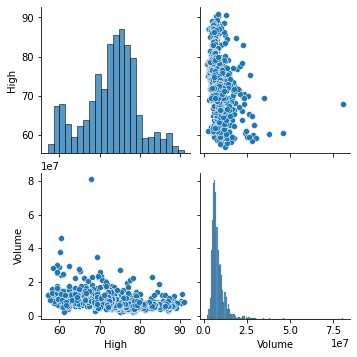

In [ ]:
import seaborn as sns

sns.pairplot(df1.select("High","Volume").toPandas())
print("Pearson's correlation coeficient:", df1.corr("High", "Volume"))

What is the max High per year?

In [ ]:
from pyspark.sql import functions as fun

df2 = df1.withColumn("Year", fun.year(df1.Date))
df2.groupBy("Year").agg({"High" : "max"}).show()

+----+---------+
|Year|max(High)|
+----+---------+
|2013|    81.37|
|2014|    88.09|
|2012|     77.6|
|2015|    90.97|
|2016|    75.19|
+----+---------+



What is the average Close for each calendar month?

In [ ]:
df2 = df1.withColumn("Month", fun.month(df1.Date))
df2.groupBy("Month").agg({"Close" : "mean"}).sort("Month").show()

+-----+-----------------+
|Month|       avg(Close)|
+-----+-----------------+
|    1| 71.4480198019802|
|    2|71.30680412371134|
|    3|71.77794392523364|
|    4|72.97361904761904|
|    5|72.30971698113207|
|    6|72.49537735849057|
|    7|74.43971962616821|
|    8|73.02981818181819|
|    9|72.18411764705883|
|   10|71.57854545454543|
|   11|72.11108910891087|
|   12| 72.8479245283019|
+-----+-----------------+

